In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col
from pyspark.sql.functions import collect_list
from pyspark.sql.functions import avg
from pyspark.sql.functions import expr
from pyspark.sql.functions import count
from pyspark.sql.functions import sum as _sum
import matplotlib.pyplot as plt

+--------------+--------------------+
|rounded_rating|            variance|
+--------------+--------------------+
|           0.0|                NULL|
|           0.5|  12.518863645297616|
|           1.0| -24.791704930301222|
|           1.5|  -2.861303960641885|
|           2.0|  -8.857105217230917|
|           2.5|  -5.651182296639095|
|           3.0|   3.876216814785457|
|           3.5|   5.337766577618217|
|           4.0|  22.147709484049017|
|           4.5|6.217248937900877...|
|           5.0|                NULL|
+--------------+--------------------+



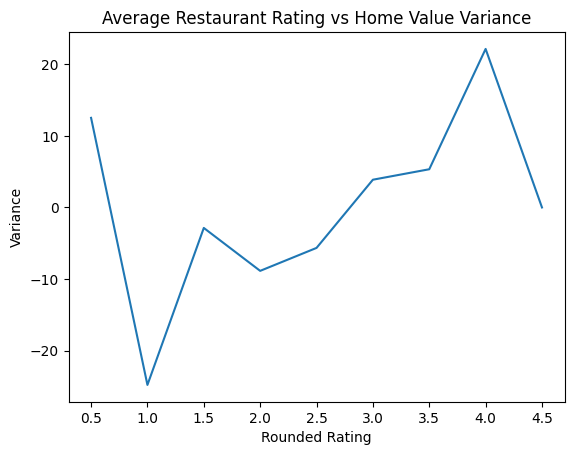

Correlation between rating and home value compared to cluster average: 0.10459707893242139


In [10]:
def average_restaurant_rating_vs_home_value():
    spark = SparkSession.builder.appName("Restaurant Home Prices").getOrCreate()

    clusters_df = spark.read.option("multiline",True).json("input/cluster") 

    clusters_df = clusters_df.selectExpr("query.average_zhvi", "query.code", "explode(results) as result")  
    clusters_df = clusters_df.withColumnRenamed("code", "cluster_code")
    clusters_df = clusters_df.withColumnRenamed("average_zhvi", "cluster_average_zhvi")
    
    clusters_df = clusters_df.select("cluster_code", "cluster_average_zhvi", "result.code", "result.zhvi")
    clusters_df = clusters_df.withColumnRenamed("code", "zip_code")

    # Now get restaurant data and combine with combined_df
    restaurants_df = spark.read.option("multiline",True).json("input/yelp/restaurants") 
    restaurants_df = restaurants_df.select(explode("businesses").alias("business"))
    # I want the 'alias' 'location.zip_code', 'review_count'  'rating'
    restaurants_df = restaurants_df.select("business.alias", "business.location.zip_code", "business.rating")
    restaurants_df = restaurants_df.withColumnRenamed("zip_code", "business_zipcode")
    # Join with combined_df
    combined_df = clusters_df.join(restaurants_df, clusters_df.zip_code == restaurants_df.business_zipcode, "inner")  
    combined_df = combined_df.drop("business_zipcode")
    combined_df = combined_df.dropDuplicates()      

    # Get the average yelp review score for each 'zip_code'
    average_df = combined_df.groupBy("zip_code").agg(avg("rating").alias("avg_rating"))
    agg_df = combined_df.groupBy("zip_code").agg(collect_list("alias").alias("restaurants"))
    average_df = average_df.join(combined_df, "zip_code", "inner")
    average_df = average_df.join(agg_df, "zip_code", "inner")
    average_df = average_df.drop("alias")
    average_df = average_df.drop("rating")
    average_df = average_df.dropDuplicates()  

    variance_df = average_df.withColumn("variance", expr("(zhvi - cluster_average_zhvi) / cluster_average_zhvi * 100"))
    variance_df = variance_df.withColumn("rounded_rating", expr("round(avg_rating * 2) / 2"))
    chart_df = variance_df.groupBy("rounded_rating").agg(avg("variance").alias("variance")).sort("rounded_rating")
    chart_df.show()

    # Plotting the chart
    x = chart_df.select("rounded_rating").rdd.flatMap(lambda x: x).collect()
    y = chart_df.select("variance").rdd.flatMap(lambda x: x).collect()
    
    plt.plot(x, y)
    plt.xlabel("Rounded Rating")
    plt.ylabel("Variance")
    plt.title("Average Restaurant Rating vs Home Value Variance")
    plt.show()    

    correlation = variance_df.corr("avg_rating", "variance")
    print("Correlation between rating and home value compared to cluster average:", correlation)


    spark.stop()

average_restaurant_rating_vs_home_value()

+------+------------------+
|rating|  avg_review_count|
+------+------------------+
|   1.0| 1.717241379310345|
|   1.1| 35.42857142857143|
|   1.2|31.692307692307693|
|   1.3| 27.59090909090909|
|   1.4|39.325581395348834|
|   1.5| 40.32786885245902|
|   1.6|50.309859154929576|
|   1.7|              46.0|
|   1.8| 62.13414634146341|
|   1.9| 83.36263736263736|
|   2.0| 35.36866359447004|
|   2.1| 80.57446808510639|
|   2.2|  78.2156862745098|
|   2.3| 45.58914728682171|
|   2.4| 72.41121495327103|
|   2.5| 65.38011695906432|
|   2.6| 72.55395683453237|
|   2.7|115.21538461538462|
|   2.8|111.35185185185185|
|   2.9|114.64084507042253|
+------+------------------+
only showing top 20 rows



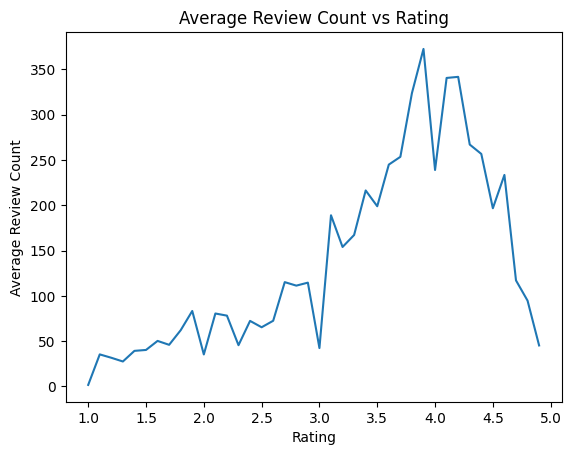

Correlation between rating score and number of reviews: 0.20052021579494841


In [26]:
def correlation_between_number_of_ratings_and_rating():
    spark = SparkSession.builder.appName("Number Of Ratings Comparision").getOrCreate()

    # Now get restaurant data and combine with combined_df
    restaurants_df = spark.read.option("multiline",True).json("input/yelp/restaurants") 
    restaurants_df = restaurants_df.select(explode("businesses").alias("business"))
    # I want the 'alias' 'location.zip_code', 'review_count'  'rating'
    restaurants_df = restaurants_df.select("business.alias", "business.location.zip_code", "business.rating", "business.review_count")
    # remove restauarants with no review count
    restaurants_df = restaurants_df.filter("review_count > 0")
    # Rfemove restaurants with a rating of 5.0
    restaurants_df = restaurants_df.filter("rating != 5.0")
    # restaurants_df.show()

    chart_df = restaurants_df.groupBy("rating").agg(avg("review_count").alias("avg_review_count")).sort("rating")
    # Remove 5.0 rating. It is an outlier
    # chart_df = chart_df.filter("rating != 5.0")
    chart_df.show()

    x = chart_df.select("rating").rdd.flatMap(lambda x: x).collect()
    y = chart_df.select("avg_review_count").rdd.flatMap(lambda x: x).collect()

    plt.plot(x, y)
    plt.xlabel("Rating")
    plt.ylabel("Average Review Count")
    plt.title("Average Review Count vs Rating")
    plt.show()

    correlation = restaurants_df.corr("rating", "review_count")
    print("Correlation between rating score and number of reviews:", correlation)

    spark.stop()

correlation_between_number_of_ratings_and_rating()

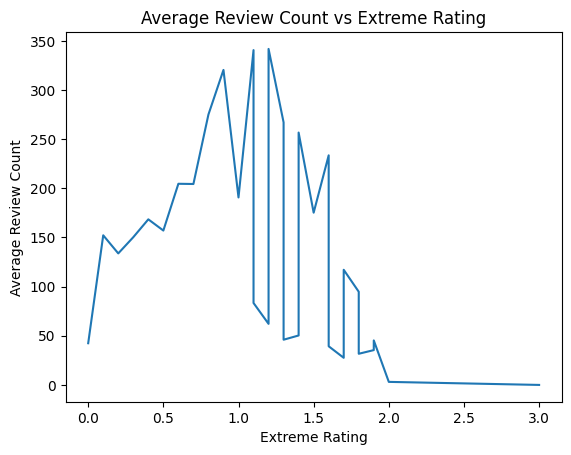

Correlation between extreme rating score and number of reviews: -0.23353065224887215


In [30]:
def ratings_vs_extreme():
    spark = SparkSession.builder.appName("Number Of Ratings Comparision").getOrCreate()

    # Now get restaurant data and combine with combined_df
    restaurants_df = spark.read.option("multiline",True).json("input/yelp/restaurants") 
    restaurants_df = restaurants_df.select(explode("businesses").alias("business"))
    # I want the 'alias' 'location.zip_code', 'review_count'  'rating'
    restaurants_df = restaurants_df.select("business.alias", "business.location.zip_code", "business.rating", "business.review_count")
    # make 2.5 rating 0 anything under is negative and anything over is positive then get the abs value
    restaurants_df = restaurants_df.withColumn("extreme_rating", expr("abs(3 - rating)"))
    # restaurants_df.show()

    chart_df = restaurants_df.groupBy("extreme_rating").agg(avg("review_count").alias("avg_review_count")).sort("extreme_rating")

    x = chart_df.select("extreme_rating").rdd.flatMap(lambda x: x).collect()
    y = chart_df.select("avg_review_count").rdd.flatMap(lambda x: x).collect()
    plt.plot(x, y) 
    plt.xlabel("Extreme Rating")
    plt.ylabel("Average Review Count")
    plt.title("Average Review Count vs Extreme Rating")
    plt.show()

    correlation = restaurants_df.corr("extreme_rating", "review_count")
    print("Correlation between extreme rating score and number of reviews:", correlation)

ratings_vs_extreme()

In [34]:

def price_correlation_between_starbucks_and_home_value():
        spark = SparkSession.builder.appName("Starbucks Comparision").getOrCreate()

        clusters_df = spark.read.option("multiline",True).json("input/cluster") 

        clusters_df = clusters_df.selectExpr("query.average_zhvi", "query.code", "explode(results) as result")  
        clusters_df = clusters_df.withColumnRenamed("code", "cluster_code")
        clusters_df = clusters_df.withColumnRenamed("average_zhvi", "cluster_average_zhvi")
    
        clusters_df = clusters_df.select("cluster_code", "cluster_average_zhvi", "result.code", "result.zhvi")
        clusters_df = clusters_df.withColumnRenamed("code", "zip_code")

        starbucks_df = spark.read.option("multiline",True).json("input/yelp/starbucks") 
        starbucks_df = starbucks_df.select(explode("businesses").alias("business"))
        starbucks_df = starbucks_df.select("business.alias", "business.location.zip_code",)
        starbucks_df = starbucks_df.withColumnRenamed("zip_code", "starbucks_zip_code")
        starbucks_df = starbucks_df.dropDuplicates()
        # Filter where alias has starbucks in it
        starbucks_df = starbucks_df.filter(starbucks_df['alias'].contains("starbucks"))
        # Add column to count starbucks in zipcode
        starbucks_df = starbucks_df.groupBy("starbucks_zip_code").agg(count("*").alias("count"))

        # join with clusters
        combined_df = clusters_df.join(starbucks_df, clusters_df.zip_code == starbucks_df.starbucks_zip_code, "left")
        # replace null in count with 0
        combined_df = combined_df.na.fill(0, subset=["count"])
        # combined_df = starbucks_df.withColumn("has_starbucks", combined_df["count"] > 0)
        # Add a column that is 1 if the count is > 0 or 0 if < 1
        combined_df = combined_df.withColumn("has_starbucks", expr("IF(count > 0, 1, 0)"))


        variance_df = combined_df.withColumn("variance", expr("(zhvi - cluster_average_zhvi) / cluster_average_zhvi * 100"))

        correlation = variance_df.corr("has_starbucks", "variance")

        print("Correlation between the existence of Starbucks and variance in home values:", correlation)

        correlation = variance_df.corr("count", "variance")
        print("Correlation between number of Starbucks and variance in home values:", correlation)

        # Find the average variance for zip codes with a starbucks and without
        correlation_df = variance_df.groupBy("has_starbucks").agg(avg("variance").alias("avg_variance"))
        correlation_df.show()

        spark.stop()

price_correlation_between_starbucks_and_home_value()

Correlation between the existance of Starbucks and variance in home values: 0.046603516369339876
Correlation between number of Starbucks and variance in home values: 0.07460434423204428
+-------------+------------------+
|has_starbucks|      avg_variance|
+-------------+------------------+
|            1|3.7679580798474848|
|            0| -3.36154212607967|
+-------------+------------------+



+-------------+--------------------+
|reviews_count|            variance|
+-------------+--------------------+
|            2|   39.50429422908574|
|            3| -16.804970947567952|
|            4|   68.17581833194821|
|            5|  31.079294980827033|
|            8|   4.611014782852172|
|           14| -40.346218872856454|
|           15|   238.4433479484545|
|           17| -1.9102581709192605|
|           25|-0.42322974351258225|
|           41|  -7.610295837335892|
|           46|  -73.44028686066657|
|           52|  -9.800548475072095|
|           54|   13.27115330724331|
|           56|  -57.62314235815684|
|           57| -58.373377009932106|
|           58|  -43.90177256521866|
|           60|  -59.18945404737654|
|           61| -46.698704593388946|
|           66| -61.569231500471666|
|           67| -29.790860096662403|
+-------------+--------------------+
only showing top 20 rows



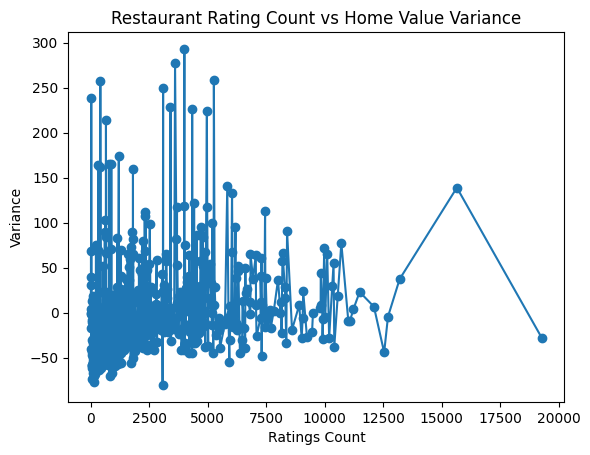

Correlation between rating count and home value compared to cluster average: 0.21576729744687795


In [65]:
def restaurant_ratings_count_to_home_value():
    spark = SparkSession.builder.appName("Restaurant Ratings Count Comparision").getOrCreate()

    clusters_df = spark.read.option("multiline",True).json("input/cluster") 

    clusters_df = clusters_df.selectExpr("query.average_zhvi", "query.code", "explode(results) as result")  
    clusters_df = clusters_df.withColumnRenamed("code", "cluster_code")
    clusters_df = clusters_df.withColumnRenamed("average_zhvi", "cluster_average_zhvi")

    clusters_df = clusters_df.select("cluster_code", "cluster_average_zhvi", "result.code", "result.zhvi")
    clusters_df = clusters_df.withColumnRenamed("code", "zip_code")

    # Now get restaurant data and combine with combined_df
    restaurants_df = spark.read.option("multiline",True).json("input/yelp/restaurants")
    restaurants_df = restaurants_df.select(explode("businesses").alias("business"))
    restaurants_df = restaurants_df.select("business.alias", "business.location.zip_code", "business.rating", "business.review_count")
    restaurants_df = restaurants_df.withColumnRenamed("zip_code", "business_zipcode")

    restaurants_df = restaurants_df.withColumn("review_count", col("review_count").cast("int"))
    # Get sum of review_count in a zipcode
    restaurants_df = restaurants_df.groupBy("business_zipcode").agg(_sum("review_count").alias("reviews_count"))

    combined_df = clusters_df.join(restaurants_df, clusters_df.zip_code == restaurants_df.business_zipcode, "inner")

    variance_df = combined_df.withColumn("variance", expr("(zhvi - cluster_average_zhvi) / cluster_average_zhvi * 100"))
    # remove where variance is null
    variance_df = variance_df.filter("variance IS NOT NULL")
    chart_df = variance_df.groupBy("reviews_count").agg(avg("variance").alias("variance")).sort("reviews_count")
    
    chart_df.show()

    # Plotting the chart
    x = chart_df.select("reviews_count").rdd.flatMap(lambda x: x).collect()
    y = chart_df.select("variance").rdd.flatMap(lambda x: x).collect()  
    plt.plot(x, y)
    plt.xlabel("Ratings Count")
    plt.ylabel("Variance")
    plt.title("Restaurant Rating Count vs Home Value Variance")
    plt.show()

    correlation = variance_df.corr("reviews_count", "variance")
    print("Correlation between rating count and home value compared to cluster average:", correlation)
    
restaurant_ratings_count_to_home_value()
    

In [67]:
def restaurant_count_correlation_to_rating():
    spark = SparkSession.builder.appName("Cont Comparision").getOrCreate()

    restaurants_df = spark.read.option("multiline",True).json("input/yelp/restaurants") 
    restaurants_df = restaurants_df.select(explode("businesses").alias("business"))
    # I want the 'alias' 'location.zip_code', 'review_count'  'rating'
    restaurants_df = restaurants_df.select("business.alias", "business.location.zip_code", "business.rating")
    # group by zip code and count the number of restaurants 
    restaurant_count = restaurants_df.groupBy("zip_code").agg(count("*").alias("count") )
    restaurant_count = restaurant_count.withColumnRenamed("zip_code", "restaurant_zip_code")
    # I need the average rating of the restaurants in the zip code
    restaurant_avg_rating = restaurants_df.groupBy("zip_code").agg(avg("rating").alias("avg_rating") )
    # restaurant_count = restaurants_df.groupBy("zip_code").agg(count("*").alias("count") )
    # join with restaurants
    combined_df = restaurants_df.join(restaurant_count, restaurants_df["zip_code"] == restaurant_count["restaurant_zip_code"], "inner")
    combined_df = combined_df.join(restaurant_avg_rating, restaurants_df["zip_code"] == restaurant_avg_rating["zip_code"], "inner")

    correlation = combined_df.corr("count", "avg_rating")
    print("Correlation between a zip code's restaurant count and rating:", correlation)

restaurant_count_correlation_to_rating()


24/04/19 14:23:09 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Correlation between a zip code's restaurant count and rating: 0.04740139081041118
